Import requirements, and suppress warnings from Sklearn

In [22]:
pip install lightgbm --upgrade


     |████████████████████████████████| 2.0 MB 7.9 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import precision_score, recall_score, f1_score, plot_confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.externals import joblib
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as pipe_imb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Read data and inspect final 5 rows of DataFrame

In [24]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Kaggle-credit-card-customers/BankChurners.csv')
df.tail()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
10122,772366833,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,3,2,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462,0.000191,0.999810
10123,710638233,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,4,2,3,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511,0.995270,0.004729
10124,716506083,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,5,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000,0.997880,0.002118
10125,717406983,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,4,3,3,5281.0,0,5281.0,0.535,8395,62,0.722,0.000,0.996710,0.003294
10126,714337233,Attrited Customer,43,F,2,Graduate,Married,Less than $40K,Silver,25,6,2,4,10388.0,1961,8427.0,0.703,10294,61,0.649,0.189,0.996620,0.003377


There are 2 columns which need to be deleted - the last 2

In [25]:
df = df.drop(
    ['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 
     'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'
     ],
      axis=1)

In [26]:
df.columns

Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

Inspecting the target label counts we can see this will be an imblanced classification problem.

In [27]:
df['Attrition_Flag'].value_counts()

Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64

Encode the target label (*Attrition_Flag*) in a seperate array and drop this and *CLIENTNUM* from the feature DataFrame.

In [28]:
le = LabelEncoder()
le.classes_ = np.array(['Existing Customer', 'Attrited Customer']) # Override label order so Churn = 1
y = le.transform(df['Attrition_Flag'])
df = df.drop(['Attrition_Flag', 'CLIENTNUM'], axis=1)

Group features into the following:


*   Categorical features: Most of these will be one-hot encoded, however if there are only two distinct variables we will binary encode instead
*   Numerical features: continuous variables that will be scaled during preprocessing
*   Binary Categorical Features: Categorical features with only two distinct values. Will be binary encoded.



In [29]:
CATEGORICAL_FEATURES = ['Gender','Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
NUMERICAL_FEATURES = [col for col in df.columns if col not in CATEGORICAL_FEATURES]

Preprocessing DataFrame using ColumnTransformer.

In [30]:
preprocessing_pipeline = ColumnTransformer(transformers=[
    ('num', StandardScaler(), NUMERICAL_FEATURES),
    ('cat', OneHotEncoder(sparse=False), CATEGORICAL_FEATURES)
])

df_new = pd.DataFrame(preprocessing_pipeline.fit_transform(df))

This code section retrieves feature (column) names for our preprocessed DataFrame. This will be useful for plotting feature importance.

In [31]:
l_transformers = list(preprocessing_pipeline._iter(fitted=True))
column_names = []
for name, trans, column, _ in l_transformers:
  if hasattr(trans, 'get_feature_names'):
    column_names.extend(trans.get_feature_names(column))
  else:
    column_names.extend(column)

In [32]:
df_new.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36
0,-0.165406,0.503368,0.384621,0.763943,-1.327136,0.492404,0.446622,-0.473422,0.488971,2.623494,-0.959707,-0.973895,3.834003,-0.775882,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.333570,2.043199,1.010715,1.407306,-1.327136,-0.411616,-0.041367,-0.366667,-0.008486,3.563293,-0.916433,-1.357340,12.608573,-0.616276,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.583058,0.503368,0.008965,0.120579,-1.327136,-2.219655,-0.573698,-1.426858,-0.445658,8.367214,-0.740982,-1.911206,6.807864,-0.997155,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.789126,1.273283,-0.241473,-0.522785,1.641478,-1.315636,-0.585251,1.661686,-0.734100,2.942843,-0.951758,-1.911206,6.807864,1.759686,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,-0.789126,0.503368,-1.869317,0.763943,-1.327136,-2.219655,-0.430877,-1.426858,-0.302868,6.455682,-1.056263,-1.570365,7.509325,-0.997155,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Standard Train-Test split.

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df_new, y, test_size=0.3, random_state=11)

### Model Training and Tuning

We are using a combination of minority over-sampling (BorderlineSMOTE) and majority random under-sampling to tackle the target class imbalance.

Model architecture: LightGBM

First step is a 5-fold randomized hyper-parmater search for the LGBM paramaters. We fix learning rate (0.03) and n_estimators (100).

F1 Scoring is used based on target class balance and business problem.

In [34]:
sm = BorderlineSMOTE(sampling_strategy=0.3)
rus = RandomUnderSampler(sampling_strategy=0.6)

lgb = LGBMClassifier(objective = 'binary')
train_pipeline = pipe_imb([('sm', sm), ('rus', rus), ('clf', lgb)])
param_dist = {'clf__n_estimators': [100],
              'clf__learning_rate': [0.03],
              'clf__subsample': [i/10.0 for i in range(6,10)],
              'clf__max_depth': [3, 4, 5, 6],
              'clf__colsample_bytree': [i/10.0 for i in range(6,10)],
              'clf__min_child_weight': range(1,6,2)
             }

clf = RandomizedSearchCV(train_pipeline, 
                         param_distributions = param_dist,
                         cv = 5,  
                         n_iter = 20,  
                         scoring = 'f1', 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1)

clf.fit(X_train.values, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   48.6s finished


RandomizedSearchCV(cv=5, error_score=0,
                   estimator=Pipeline(memory=None,
                                      steps=[('sm',
                                              BorderlineSMOTE(k_neighbors=5,
                                                              kind='borderline-1',
                                                              m_neighbors=10,
                                                              n_jobs=1,
                                                              random_state=None,
                                                              sampling_strategy=0.3)),
                                             ('rus',
                                              RandomUnderSampler(random_state=None,
                                                                 ratio=None,
                                                                 replacement=False,
                                                                 return_indices=F

In [35]:
clf.best_score_, clf.best_params_

(0.8591217931344692,
 {'clf__colsample_bytree': 0.7,
  'clf__learning_rate': 0.03,
  'clf__max_depth': 6,
  'clf__min_child_weight': 5,
  'clf__n_estimators': 100,
  'clf__subsample': 0.8})

Custom evaluation metric for use in the next section.

In [36]:
def lgb_f1_score(y_hat, data):
    y_true = np.where(data > 0.5, 1, 0)
    return 'f1', f1_score(y_true, y_hat), True

Using the best parameters from the random search, we increase n_estimators and use the LGBM early stopping implementation to optimise this parameter.

5-fold stratified CV is used with our custom f1 eval metric defined above.

In [37]:
lgbm =  clf.best_estimator_.steps[-1][-1]
params = {'learning_rate':0.03, 'n_estimators':5000}
lgbm.set_params(**params)
train_pipeline_es = pipe_imb([('sm', sm), ('rus', rus), ('clf', lgbm)])

kf= StratifiedKFold(shuffle = True)

stopping_rounds = []

for train_index, test_index in kf.split(X_train, y_train):
  X_train2, X_val = X_train.values[train_index], X_train.values[test_index]
  y_train2, y_val = y_train[train_index], y_train[test_index]

  fit_params={"clf__early_stopping_rounds":50, 
            "clf__eval_metric" : lgb_f1_score, 
            "clf__eval_set" : [[X_val, y_val]],
            "clf__verbose": 25}


  train_pipeline_es.fit(X_train2, y_train2, **fit_params)

  stopping_rounds.append(train_pipeline_es.steps[-1][-1].booster_.best_iteration)


/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[25]	valid_0's binary_logloss: 0.319662	valid_0's f1: 0.816327
[50]	valid_0's binary_logloss: 0.229022	valid_0's f1: 0.844639
[75]	valid_0's binary_logloss: 0.178622	valid_0's f1: 0.847826
[100]	valid_0's binary_logloss: 0.152138	valid_0's f1: 0.852814
[125]	valid_0's binary_logloss: 0.13647	valid_0's f1: 0.852814
[150]	valid_0's binary_logloss: 0.127085	valid_0's f1: 0.852814


/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[25]	valid_0's binary_logloss: 0.315171	valid_0's f1: 0.853392
[50]	valid_0's binary_logloss: 0.222434	valid_0's f1: 0.861996
[75]	valid_0's binary_logloss: 0.17223	valid_0's f1: 0.870488
[100]	valid_0's binary_logloss: 0.14407	valid_0's f1: 0.881356
[125]	valid_0's binary_logloss: 0.127119	valid_0's f1: 0.883227
[150]	valid_0's binary_logloss: 0.116478	valid_0's f1: 0.89172
[175]	valid_0's binary_logloss: 0.107991	valid_0's f1: 0.893162
[200]	valid_0's binary_logloss: 0.10173	valid_0's f1: 0.895075


/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[25]	valid_0's binary_logloss: 0.316873	valid_0's f1: 0.823266
[50]	valid_0's binary_logloss: 0.224442	valid_0's f1: 0.845494
[75]	valid_0's binary_logloss: 0.17669	valid_0's f1: 0.84188
[100]	valid_0's binary_logloss: 0.152632	valid_0's f1: 0.849785


/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[25]	valid_0's binary_logloss: 0.322636	valid_0's f1: 0.826966
[50]	valid_0's binary_logloss: 0.232218	valid_0's f1: 0.843478
[75]	valid_0's binary_logloss: 0.181784	valid_0's f1: 0.856531
[100]	valid_0's binary_logloss: 0.153947	valid_0's f1: 0.854123
[125]	valid_0's binary_logloss: 0.138715	valid_0's f1: 0.854123
[150]	valid_0's binary_logloss: 0.127594	valid_0's f1: 0.862579
[175]	valid_0's binary_logloss: 0.119807	valid_0's f1: 0.860759


/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[25]	valid_0's binary_logloss: 0.323606	valid_0's f1: 0.824295
[50]	valid_0's binary_logloss: 0.23406	valid_0's f1: 0.829876
[75]	valid_0's binary_logloss: 0.183544	valid_0's f1: 0.837113
[100]	valid_0's binary_logloss: 0.156146	valid_0's f1: 0.854167
[125]	valid_0's binary_logloss: 0.140018	valid_0's f1: 0.863158
[150]	valid_0's binary_logloss: 0.130003	valid_0's f1: 0.864407
[175]	valid_0's binary_logloss: 0.12382	valid_0's f1: 0.870488
[200]	valid_0's binary_logloss: 0.1185	valid_0's f1: 0.871036
[225]	valid_0's binary_logloss: 0.113764	valid_0's f1: 0.881356
[250]	valid_0's binary_logloss: 0.109232	valid_0's f1: 0.881857
[275]	valid_0's binary_logloss: 0.105959	valid_0's f1: 0.885593
[300]	valid_0's binary_logloss: 0.103943	valid_0's f1: 0.883721


Re-fit on all training data using best parameters.

In [38]:
best_estimators = int(np.ceil(np.mean(stopping_rounds)))

lgbm_final =  lgbm
params_final = {'learning_rate':0.03, 'n_estimators':best_estimators}
lgbm_final.set_params(**params_final)
train_pipeline_final = pipe_imb([('sm', sm), ('rus', rus), ('clf', lgbm_final)])

train_pipeline_final.fit(X_train.values, y_train)

Pipeline(memory=None,
         steps=[('sm',
                 BorderlineSMOTE(k_neighbors=5, kind='borderline-1',
                                 m_neighbors=10, n_jobs=1, random_state=None,
                                 sampling_strategy=0.3)),
                ('rus',
                 RandomUnderSampler(random_state=None, ratio=None,
                                    replacement=False, return_indices=False,
                                    sampling_strategy=0.6)),
                ('clf',
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=0.7, importance_type='split',
                                learning_rate=0.03, max_depth=6,
                                min_child_samples=20, min_child_weight=5,
                                min_split_gain=0.0, n_estimators=148, n_jobs=-1,
                                num_leaves=31, objective='binary',
                                random_state=None, reg_alp

Predict on test set. Note that imblearn's pipeline implementation will only use sampling methods on fit and not predict.

Print precision, recall, f1 and accuracy.

In [39]:
preds = train_pipeline_final.predict(X_test.values)

print('Precision: {}'.format(precision_score(y_test, preds)))
print('Recall: {}'.format(recall_score(y_test, preds)))
print('F1: {}'.format(f1_score(y_test, preds)))
print('Accuracy: {}'.format(accuracy_score(y_test, preds)))

Precision: 0.8777372262773723
Recall: 0.9339805825242719
F1: 0.9049858889934149
Accuracy: 0.9667653833497861


Confusion Matrix using predictions.



*   False Negative: These are want we want to avoid as it results in a missed customer that churns.
*   False Positive: Incorrectly predicting a churn. The implications of this depend on the business strategy (e.g. what is the cost of attempting to prevent a churn?).



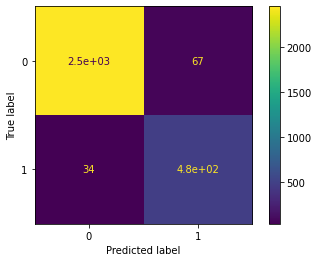

In [40]:
plot_confusion_matrix(train_pipeline_final, X_test.values, y_test)

Plot feature importances using column names extracted earlier.

In [41]:
feat_imp = train_pipeline_final.steps[-1][-1].booster_.feature_importance()
feat_imp_mapped = dict(zip(column_names, feat_imp))

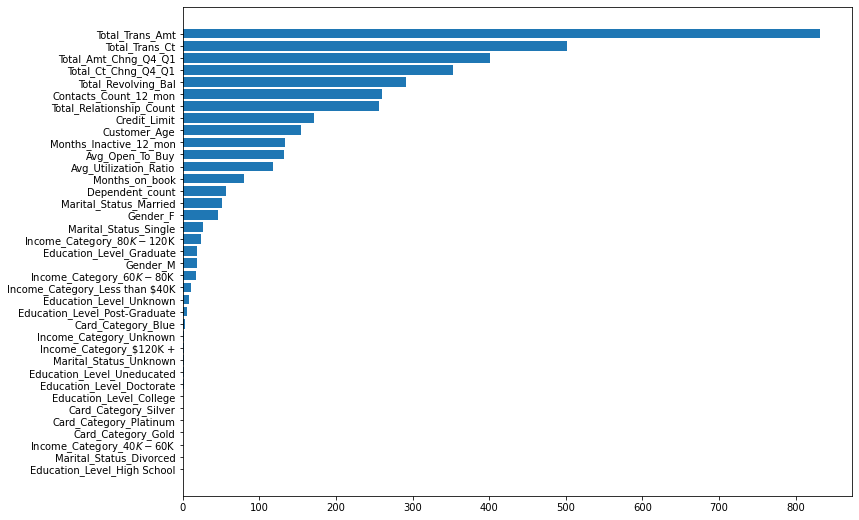

In [42]:
feat_imp_mapped = sorted(feat_imp_mapped.items(), key=lambda x:x[1])
plt.figure(figsize=(12,9))
plt.barh(range(len(feat_imp_mapped)), [x[1] for x in feat_imp_mapped], align='center')
plt.yticks(range(len(feat_imp_mapped)), [x[0] for x in feat_imp_mapped])
plt.yticks(rotation=0)
plt.show()

Save trained model and preprocessing pipeline for online inference.

In [43]:
final_model = train_pipeline_final.steps[-1][-1]

final_pipeline = Pipeline([('preprocess', preprocessing_pipeline), ('model', final_model)])

joblib.dump(final_pipeline, 'drive/MyDrive/churn_pipeline.pkl')


['drive/MyDrive/churn_pipeline.pkl']